### 1: Business Question

**Main question:**

How can Rooster use pricing data and predictive modeling to optimize profitability and improve customer retention?

**Key Analytical Goals:**
* **Classification:** Predict whether a customer will return next month.

* **Regression:** Predict how much profit a customer will generate next month.

* Use insights to recommend pricing strategies for customer segments.

### 2: Load and Join the Data

In [2]:
# Downloading the data
from urllib.request import urlretrieve
from pathlib import Path

if not Path("/content/rooster_a3_pricing.xlsx").exists():
    urlretrieve("https://drive.google.com/uc?export=download&id=1gCewYYyrVFquTf8R8EzPWvsdWSi7r8yP", "rooster_a3_pricing.xlsx")

In [22]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Loading the excel with multiple sheets
file_path = "rooster_a3_pricing.xlsx"
xls = pd.ExcelFile(file_path)

# Loading sheets
customers = pd.read_excel(xls, 'customers')
orders = pd.read_excel(xls, 'orders')
products = pd.read_excel(xls, 'products')
orderlines = pd.read_excel(xls, 'orderlines')
newsletter = pd.read_excel(xls, 'newsletters')
metrics = pd.read_excel(xls, 'metrics')
pricing = pd.read_excel(xls, 'pricing')


### 3: Exploratory Data Analysis (EDA)

**1. Price Distribution and Product Analysis**

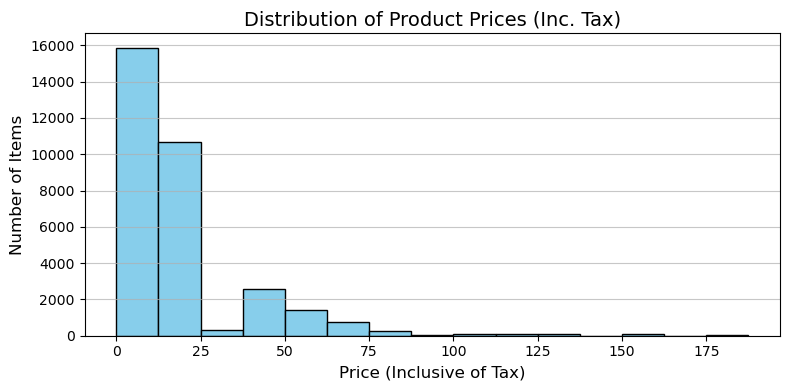

In [5]:
# Merging orderlines with products
merged_df = orderlines.merge(products, on='pvr_id')

# Plot: Price distribution
plt.figure(figsize=(8, 4))
plt.hist(merged_df['item_price_inc_tax'], 
         bins=15, color='skyblue', edgecolor='black')
plt.title('Distribution of Product Prices (Inc. Tax)', fontsize=14)
plt.xlabel('Price (Inclusive of Tax)', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)
plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.show()


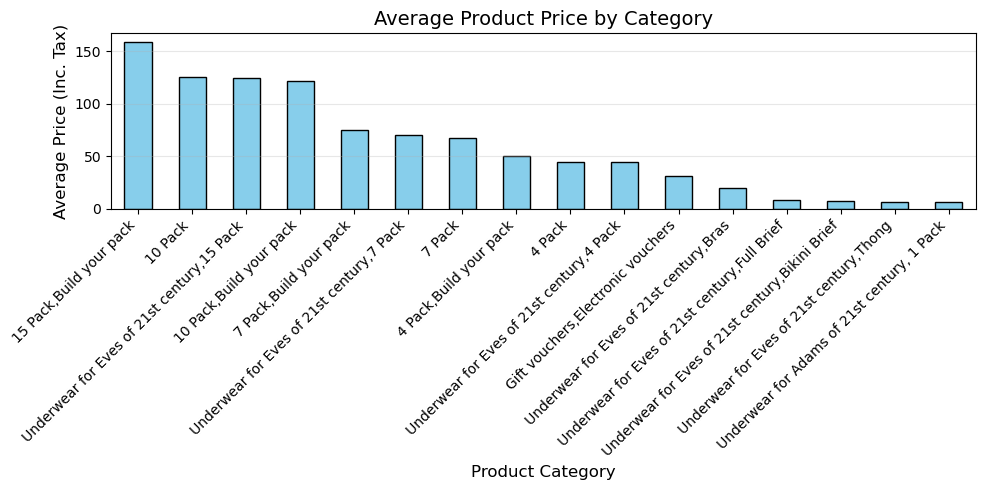

In [6]:
# Average price per product category
price_by_category = (
    merged_df.groupby('category')['item_price_inc_tax']
    .mean()
    .sort_values(ascending=False)
)

# Bar plot for average price by category
plt.figure(figsize=(10, 5))
price_by_category.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Product Price by Category', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Average Price (Inc. Tax)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**2. Customer Spend Patterns**

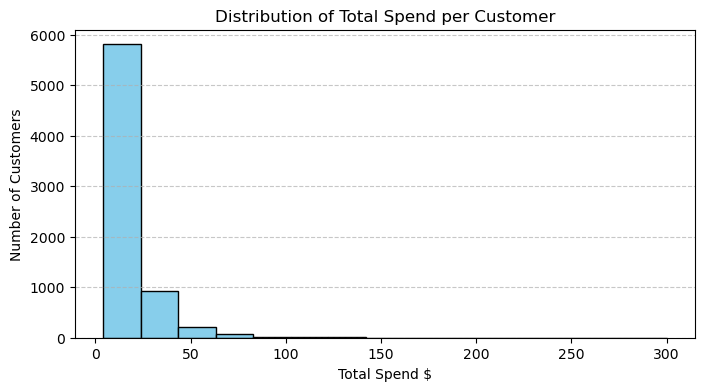

,total_units,total_cost
total_units,1.0,1.0
total_cost,1.0,1.0


In [10]:
# Total spend distribution
plt.figure(figsize=(8, 4))
plt.hist(metrics['total_cost'], bins=15, 
         color='skyblue', edgecolor='black')

plt.title("Distribution of Total Spend per Customer")
plt.xlabel("Total Spend $")
plt.ylabel("Number of Customers")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Correlation between total_units and total_cost
metrics[['total_units', 'total_cost']].corr()

**3. Retention Behavior**

In [11]:
# Count of repeat vs one-time
metrics['repeat_customer'].value_counts(normalize=True)

# Days to second order (only for repeat customers)
metrics[metrics['repeat_customer'] == True]['days_to_second_order'].describe()


count    2059.000000
mean       99.092278
std        97.262747
min         0.000000
25%        21.000000
50%        66.000000
75%       149.000000
max       505.000000
Name: days_to_second_order, dtype: float64

### 4: Feature Engineering

In [ ]:
# Join orders with orderlines
ol_order = orderlines.merge(orders, on='order_id')

# Calculate line profit (line_price - cost)
ol_order['line_profit'] = ol_order[
    'line_price_before_discount_inc'] - ol_order['cost']

# Profit per customer per month
monthly_profit = ol_order.groupby(['customer_email', 
                                   pd.to_datetime(ol_order[
                                       'order_date']).dt.to_period(\
                                       'M')])['line_profit'].sum().reset_index()
monthly_profit.columns = ['customer_email', 'month', 'monthly_profit']


### 5: Predictive Modeling

**1. Classification: Will the Customer Return?**

In [ ]:
X = metrics[['days_active', 'days_inactive', 
             'total_units', 'total_cost', 'first_order_amount']]
y = metrics['repeat_customer']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2122
           1       1.00      1.00      1.00       618

    accuracy                           1.00      2740
   macro avg       1.00      1.00      1.00      2740
weighted avg       1.00      1.00      1.00      2740



**2. Regression: Predict Customer Profit**

In [ ]:
# Merge profit data with features
reg_df = metrics.merge(monthly_profit.groupby('customer_email')
                       ['monthly_profit'].mean().reset_index(), on='customer_email')

X = reg_df[['days_active', 'days_inactive', 'total_units', 'total_cost']]
y = reg_df['monthly_profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg_model = RandomForestRegressor()
reg_model.fit(X_train, y_train)
y_pred = reg_model.predict(X_test)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R2:", r2_score(y_test, y_pred))

RMSE: 8.517053742569749
R2: 0.8458066368092116


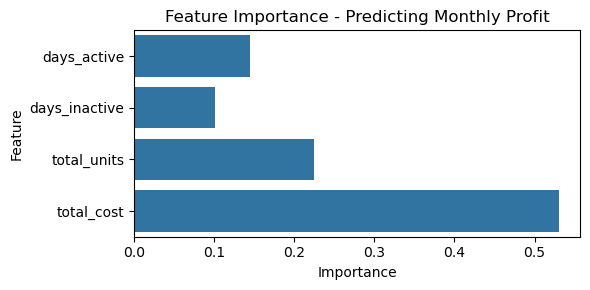

In [ ]:
# Getting feature importances
importances = reg_model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(6, 3))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance - Predicting Monthly Profit")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()